In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys
import logging
import pickle
import logging

# Data
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Graph
import tensorflow_gnn as tfgnn

# Add the project root to the Python path
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.data_cleaner import filter_top_cpv_categories
#from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer
from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer
from scripts.synthetic_anomaly_generator import analyze_original_dataset_anomalies, OriginalAnomalyRemover



%load_ext autoreload
%autoreload 2

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


2025-06-09 18:22:17.804894: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 18:22:17.855417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 18:22:18.163393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 18:22:18.163456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 18:22:18.165022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Configuration
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),
                        'data')
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()),
                            'models', 'anomalies')
os.makedirs(MODEL_PATH, exist_ok=True)

# Initialize components
graph_builder = ProcurementGraphBuilder()
gnn_detector = GNNAnomalyDetector(hidden_dim=64, output_dim=32,
                                    num_layers=3)
analyzer = AnomalyAnalyzer()

In [4]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),
                        'data')
 
# Load and preprocess data
X = graph_builder.load_data(DATA_PATH)

INFO:scripts.gnn_anomaly_detection:Loading data from /home/ronan/code/RonanB400/Project/decp_ml/data


In [9]:
X_filtered = filter_top_cpv_categories(X, top_n=400, cpv_column='codeCPV_4')
X_filtered['codeCPV_4'].value_counts()

Filtered from 1222 to 400 CPV categories, keeping 277081 rows out of 286850


codeCPV_4
45230000    20954
45210000    18606
45110000    13263
45260000    12687
45000000     9794
            ...  
22200000       50
44410000       49
28210000       49
92600000       49
50500000       49
Name: count, Length: 400, dtype: int64

In [ ]:
X_filtered

(277081, 38)

In [4]:
# Now using all three splits: train, val, test (with synthetic anomalies)
(X_train_preproc, X_val_preproc, X_test_preproc, 
    X_train, X_val, X_test) = graph_builder.preprocess_data(X)

# Create graphs for all three splits
X_train_graph = graph_builder.create_graph(X_train_preproc, X_train, type='train')
X_val_graph = graph_builder.create_graph(X_val_preproc, X_val, type='val')
X_test_graph = graph_builder.create_graph(X_test_preproc, X_test, type='test')

INFO:scripts.gnn_anomaly_detection:Preprocessing data...


Filtered from 392 to 60 CPV categories, keeping 250895 rows out of 286850


INFO:scripts.gnn_anomaly_detection:Removing original anomalies from training and validation sets...
INFO:scripts.gnn_anomaly_detection:Cleaning training set...
INFO:scripts.synthetic_anomaly_generator:Identifying original anomalies for removal...
INFO:scripts.synthetic_anomaly_generator:Checking for: single_bid_competitive, price_inflation, price_deflation, high_market_concentration, temporal_clustering, suspicious_buyer_supplier_pairs
INFO:scripts.synthetic_anomaly_generator:single_bid_competitive: found 7010 anomalies
INFO:scripts.synthetic_anomaly_generator:price_inflation: found 2827 anomalies
INFO:scripts.synthetic_anomaly_generator:price_deflation: found 0 anomalies
INFO:scripts.synthetic_anomaly_generator:high_market_concentration: found 1842 anomalies
INFO:scripts.synthetic_anomaly_generator:temporal_clustering: found 3190 anomalies
INFO:scripts.synthetic_anomaly_generator:suspicious_buyer_supplier_pairs: found 5807 anomalies
INFO:scripts.synthetic_anomaly_generator:Total uniqu

In [5]:
# Scale derived node/edge features using training data
logger.info("Scaling derived node and edge features...")

data_path = os.path.join(os.path.dirname(os.getcwd()),'data')

with open(os.path.join(data_path, 'graph_data_train.pkl'), 'rb') as f:
    X_train_graph = pickle.load(f)

with open(os.path.join(data_path, 'graph_data_val.pkl'), 'rb') as f:
    X_val_graph = pickle.load(f)

with open(os.path.join(data_path, 'graph_data_test.pkl'), 'rb') as f:
    X_test_graph = pickle.load(f)


node_features_train = X_train_graph['node_features']
edge_features_train = X_train_graph['edge_features']

# Fit scalers on training data (derived features)
node_features_train_scaled = graph_builder.node_scaler.fit_transform(
    node_features_train)
edge_features_train_scaled = graph_builder.edge_scaler.fit_transform(
    edge_features_train)

# Transform validation features using training scalers
node_features_val = X_val_graph['node_features']
edge_features_val = X_val_graph['edge_features']
node_features_val_scaled = graph_builder.node_scaler.transform(
    node_features_val)
edge_features_val_scaled = graph_builder.edge_scaler.transform(
    edge_features_val)

# Transform test features using training scalers
node_features_test = X_test_graph['node_features']
edge_features_test = X_test_graph['edge_features']
node_features_test_scaled = graph_builder.node_scaler.transform(
    node_features_test)
edge_features_test_scaled = graph_builder.edge_scaler.transform(
    edge_features_test)

# Create TensorFlow graphs for all three splits
X_train_tf_graph = gnn_detector.create_tensorflow_graph(
    X_train_graph, node_features_train_scaled, edge_features_train_scaled)
X_val_tf_graph = gnn_detector.create_tensorflow_graph(
    X_val_graph, node_features_val_scaled, edge_features_val_scaled)
X_test_tf_graph = gnn_detector.create_tensorflow_graph(
    X_test_graph, node_features_test_scaled, edge_features_test_scaled)

# Store graph tensors for later use
gnn_detector.graph_tensor_train = X_train_tf_graph
gnn_detector.graph_tensor_val = X_val_tf_graph
gnn_detector.graph_tensor_test = X_test_tf_graph

INFO:__main__:Scaling derived node and edge features...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection:Creating TensorFlow GNN graph...


# Edge anomalies

INFO:scripts.gnn_anomaly_detection:Building GNN model for edge anomaly detection...


INFO:scripts.gnn_anomaly_detection:Training edge GNN model for 500 epochs...


Epoch 1/500


1/1 [==============================] - 5s 5s/step - loss: 1.2542 - edge_embeddings_loss: 0.0398 - edge_reconstructed_loss: 1.3891 - val_loss: 0.9436 - val_edge_embeddings_loss: 0.2199 - val_edge_reconstructed_loss: 1.0240
Epoch 2/500
1/1 [==============================] - 1s 714ms/step - loss: 1.1791 - edge_embeddings_loss: 0.0437 - edge_reconstructed_loss: 1.3052 - val_loss: 0.9346 - val_edge_embeddings_loss: 0.1814 - val_edge_reconstructed_loss: 1.0183
Epoch 3/500
1/1 [==============================] - 1s 746ms/step - loss: 1.1163 - edge_embeddings_loss: 0.0424 - edge_reconstructed_loss: 1.2356 - val_loss: 0.9291 - val_edge_embeddings_loss: 0.1587 - val_edge_reconstructed_loss: 1.0147
Epoch 4/500
1/1 [==============================] - 1s 729ms/step - loss: 1.0746 - edge_embeddings_loss: 0.0387 - edge_reconstructed_loss: 1.1897 - val_loss: 0.9253 - val_edge_embeddings_loss: 0.1424 - val_edge_reconstructed_loss: 1.0122
Epoch 5/500
1/1 [==============================] - 1s 808ms/step - 

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets


INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets
INFO:scripts.gnn_anomaly_detection:Edge model saved to /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model


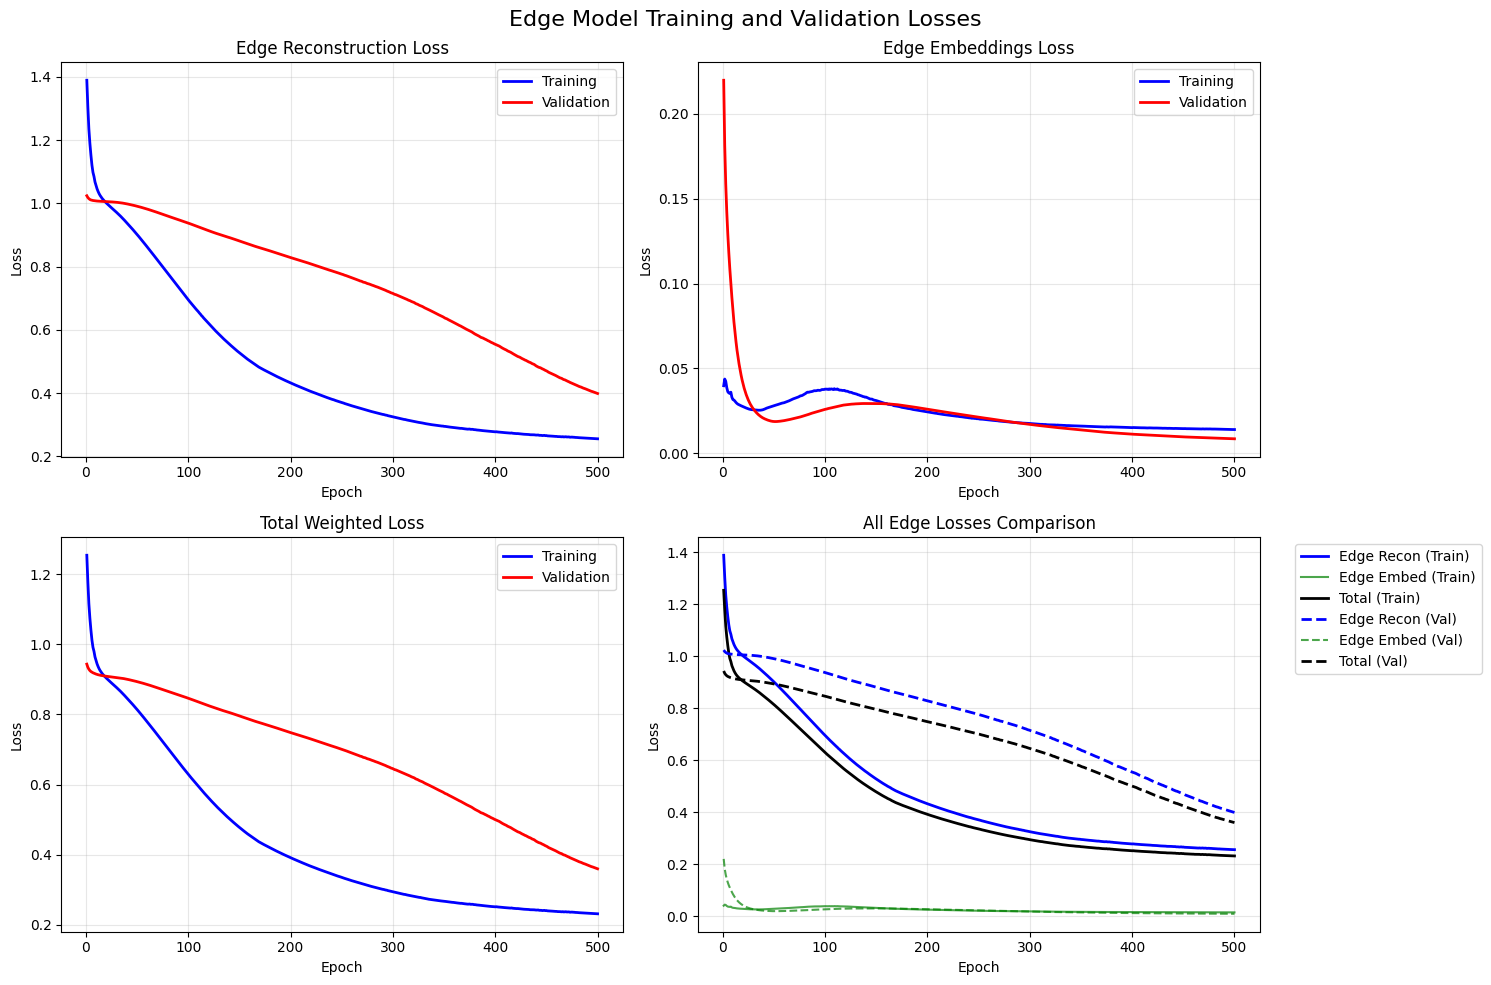


EDGE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Edge Reconstruction: 0.255447
  - Edge Embeddings: 0.013952
  - Total Weighted Loss: 0.231298

Validation Losses (Final Epoch):
  - Edge Reconstruction: 0.398699
  - Edge Embeddings: 0.008500
  - Total Weighted Loss: 0.359679

Training vs Validation Analysis:
  - ⚠️  Potential overfitting (val loss >> train loss)
      Model memorizing training data, poor generalization


In [6]:
gnn_detector.edge_model = gnn_detector.build_edge_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

edge_history = gnn_detector.train_edge_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                         epochs=500)

gnn_detector.plot_edge_training_history(edge_history)

In [7]:
edge_reconstruction_error, edge_threshold = (
            gnn_detector.detect_edge_anomalies(
                X_test_tf_graph,
                threshold_percentile = 10))
        
# Calculate anomaly masks
edge_anomalies = edge_reconstruction_error > edge_threshold

INFO:scripts.gnn_anomaly_detection:Detecting edge anomalies...
INFO:scripts.gnn_anomaly_detection:Original edge features shape: (50179, 94)
INFO:scripts.gnn_anomaly_detection:Original edge features - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Original edge features - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Original edge features stats: min=-42.833157, max=267.564026, mean=0.004437


1/1 [==============================] - 0s 451ms/step


INFO:scripts.gnn_anomaly_detection:Reconstructed edge features shape: (50179, 94)
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstructed edge features stats: min=-24.395601, max=89.620941, mean=-0.010840
INFO:scripts.gnn_anomaly_detection:Difference - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Difference - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Squared difference - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Squared difference - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors shape: (50179,)
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - NaN count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - Inf count: 0
INFO:scripts.gnn_anomaly_detection:Reconstruction errors - % NaN: 0.0%
INFO:scripts.gnn_anomaly_detection:Valid errors count: 50179 out of 50179
INFO:scripts.gnn_anomaly

In [8]:
synthetic_analysis = analyzer.analyze_synthetic_anomaly_detection(
            X_test_graph, edge_reconstruction_error, edge_threshold, threshold_percentile=10, show_plots=False)

INFO:scripts.gnn_anomaly_detection:Analyzing synthetic anomaly detection performance...



SYNTHETIC ANOMALY DETECTION ANALYSIS
Dataset Overview:
  - Total contracts: 50,179
  - Normal contracts: 45,731 (91.1%)
  - Synthetic anomalies: 4,448 (8.9%)

Performance by Threshold Percentile:
Percentile   Threshold    Precision  Recall   F1-Score Detected  
----------------------------------------------------------------------
95           1.015522     0.094      0.053    0.068    2509      
97           1.178115     0.085      0.029    0.043    1506      
99           1.769578     0.056      0.006    0.011    502       
99.5         2.696922     0.036      0.002    0.004    251       

Performance by Anomaly Type:
Type                      Count    % Dataset  Detection Rate % vs Threshold Avg Error    Status    
-------------------------------------------------------------------------------------------------
Normal                    45731    91.1       10.0            1.0x         0.428710     ⚠️ High FP
Single Bid Competitive    782      1.6        12.7            1.3x         

# Node anomalies

INFO:scripts.gnn_anomaly_detection:Building GNN model for node anomaly detection...
INFO:scripts.gnn_anomaly_detection:Training node GNN model for 50 epochs...


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.2654 - node_embeddings_loss: 0.0040 - node_reconstructed_loss: 1.4055 - val_loss: 0.9227 - val_node_embeddings_loss: 0.1299 - val_node_reconstructed_loss: 1.0107
Epoch 2/50
1/1 [==============================] - 0s 467ms/step - loss: 1.2223 - node_embeddings_loss: 0.0043 - node_reconstructed_loss: 1.3577 - val_loss: 0.9127 - val_node_embeddings_loss: 0.0902 - val_node_reconstructed_loss: 1.0041
Epoch 3/50
1/1 [==============================] - 0s 471ms/step - loss: 1.1569 - node_embeddings_loss: 0.0048 - node_reconstructed_loss: 1.2849 - val_loss: 0.9079 - val_node_embeddings_loss: 0.0695 - val_node_reconstructed_loss: 1.0011
Epoch 4/50
1/1 [==============================] - 0s 476ms/step - loss: 1.1119 - node_embeddings_loss: 0.0057 - node_reconstructed_loss: 1.2348 - val_loss: 0.9054 - val_node_embeddings_loss: 0.0575 - val_node_reconstructed_loss: 0.9997
Epoch 5/50
1/1 [==============================] - 1s 514ms/

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

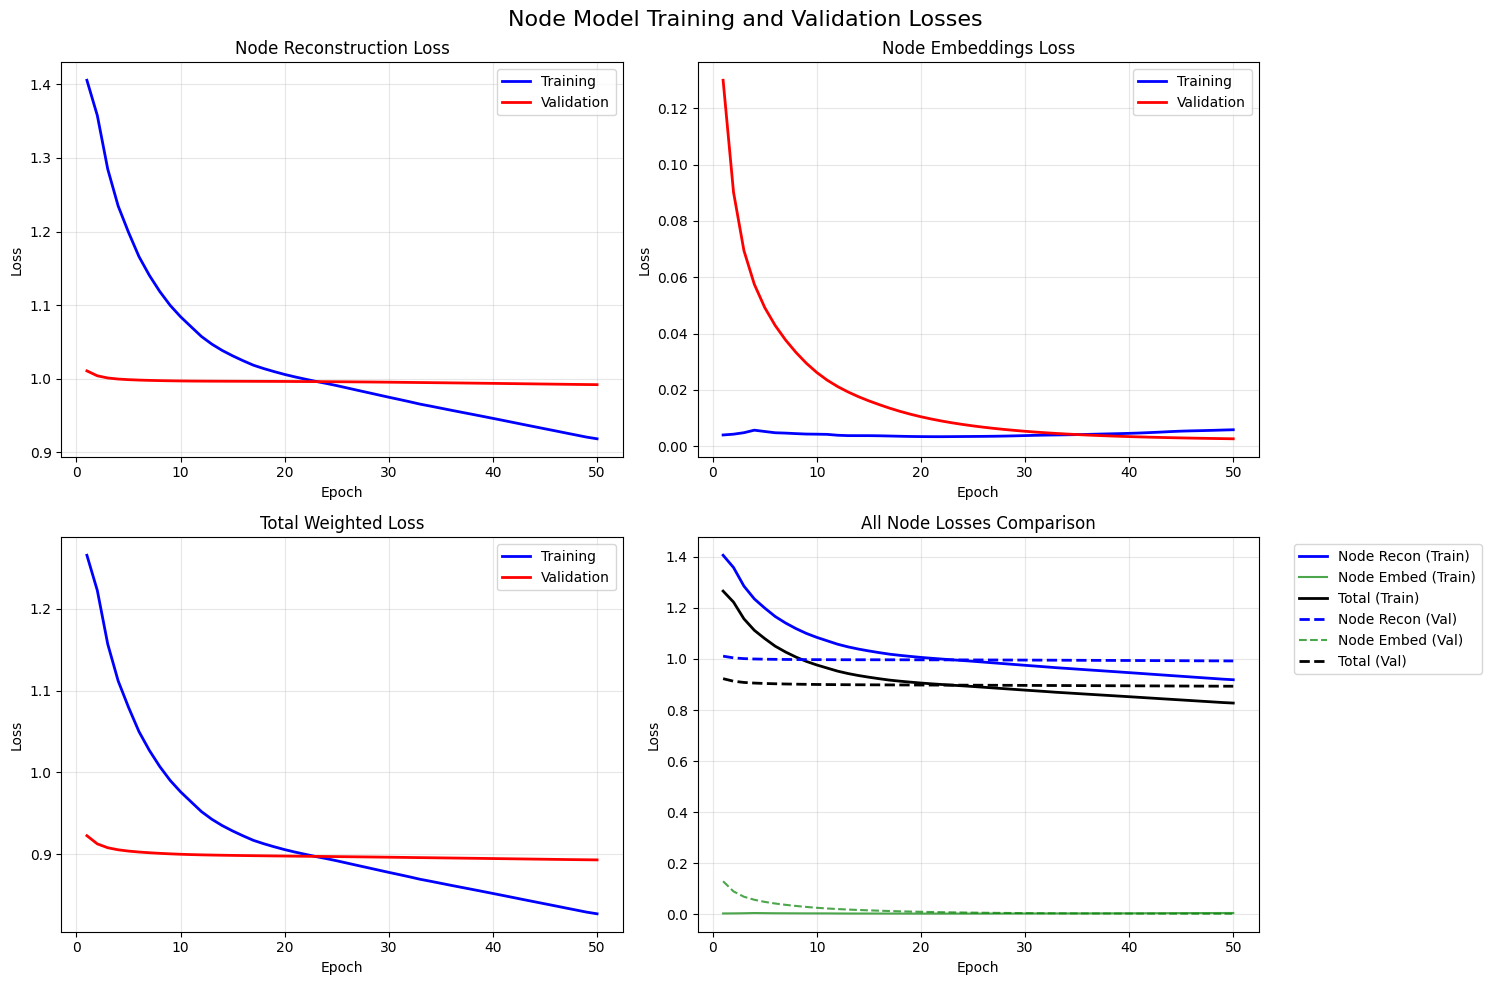


NODE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Node Reconstruction: 0.918486
  - Node Embeddings: 0.005878
  - Total Weighted Loss: 0.827225

Validation Losses (Final Epoch):
  - Node Reconstruction: 0.992036
  - Node Embeddings: 0.002668
  - Total Weighted Loss: 0.893099

Training vs Validation Analysis:
  - ⚠️  Potential overfitting (val loss >> train loss)
      Model memorizing training data, poor generalization


In [9]:
gnn_detector.node_model = gnn_detector.build_node_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

node_history = gnn_detector.train_node_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                        epochs=50)

gnn_detector.plot_node_training_history(node_history)

In [10]:

(node_reconstruction_error, edge_reconstruction_error, 
     node_threshold, edge_threshold) = gnn_detector.detect_anomalies()
    
# Calculate anomaly masks
node_anomalies = node_reconstruction_error > node_threshold
edge_anomalies = edge_reconstruction_error > edge_threshold

AttributeError: 'GNNAnomalyDetector' object has no attribute 'detect_anomalies'

In [ ]:
 #Create results analysis
graph_data = X_test_graph

analyzer = AnomalyAnalyzer()

node_results_df = analyzer.create_node_results_dataframe(
    graph_data, node_reconstruction_error, node_anomalies)

node_results_df.head()

In [ ]:
edge_results_df = analyzer.create_edge_results_dataframe(
    graph_data, edge_reconstruction_error, edge_anomalies)

edge_results_df.head()

In [ ]:
data_path

In [ ]:
model_path = os.path.join(data_path, 'gnn_anomaly_model.keras')

tf.saved_model.save(gnn_detector.model, model_path)

In [ ]:
graph_builder = ProcurementGraphBuilder()
graph_builder.visualize_procurement_graph(X_train_graph)